# Goldsmiths University of London
# MSc Data Science and Artificial Intelligence
# Final Project in Data Science (2023-24)
# Supervisor: Dr V L Raju Chinthalapati
# Author: Alperen Unal - aunal001
# Student ID: 33804283

## Phase 5- GJR-GARCH Model

## 1. Utilised Modules

In [1]:
pip install arch

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from arch import arch_model  
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## 2. Data Preprocessing

In [4]:
prediction_df = pd.read_csv("prediction_scaled_log_returns.csv")
prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31339 entries, 0 to 31338
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   spot_btc_coin_volume                  31339 non-null  float64
 1   futures_btc_close_price               31339 non-null  float64
 2   futures_btc_coin_volume               31339 non-null  float64
 3   futures_btc_coin_open_interest_close  31339 non-null  float64
 4   futures_btc_funding_rate              31339 non-null  float64
 5   futures_btc_CVD                       31339 non-null  float64
 6   futures_eth_close_price               31339 non-null  float64
 7   futures_eth_coin_open_interest_close  31339 non-null  float64
 8   futures_eth_funding_rate              31339 non-null  float64
 9   futures_eth_CVD                       31339 non-null  float64
 10  eth_etf                               31339 non-null  int64  
 11  btc_etf        

In [5]:
df = prediction_df[['futures_btc_close_price', 'futures_btc_coin_volume',
                    'futures_btc_coin_open_interest_close', 'futures_btc_funding_rate',
                    'futures_btc_CVD', 'log_returns', 'volatility']]

In [6]:
start_date = '2021-01-02 00:00:00'
end_date = '2024-07-30 18:00:00'
freq = 'H'  

datetime_index = pd.date_range(start=start_date, end=end_date, freq=freq)

df = df.set_index(datetime_index)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31339 entries, 2021-01-02 00:00:00 to 2024-07-30 18:00:00
Freq: H
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   futures_btc_close_price               31339 non-null  float64
 1   futures_btc_coin_volume               31339 non-null  float64
 2   futures_btc_coin_open_interest_close  31339 non-null  float64
 3   futures_btc_funding_rate              31339 non-null  float64
 4   futures_btc_CVD                       31339 non-null  float64
 5   log_returns                           31339 non-null  float64
 6   volatility                            31339 non-null  float64
dtypes: float64(7)
memory usage: 1.9 MB


In [8]:
df['log_returns_100'] = df['log_returns'] * 100

In [9]:
df

,futures_btc_close_price,futures_btc_coin_volume,futures_btc_coin_open_interest_close,futures_btc_funding_rate,futures_btc_CVD,log_returns,volatility,log_returns_100
2021-01-02 00:00:00,29215.89,11380.580,36013.363,0.000100,-1.080364e+04,-0.004142,0.005182,-0.414223
2021-01-02 01:00:00,29380.00,7693.401,35530.754,0.000100,-1.072782e+04,0.005601,0.004329,0.560143
2021-01-02 02:00:00,29347.02,6230.851,35781.508,0.000100,-1.051844e+04,-0.001123,0.004065,-0.112316
2021-01-02 03:00:00,29364.67,4118.911,35532.749,0.000100,-1.078220e+04,0.000601,0.004042,0.060124
2021-01-02 04:00:00,29363.03,4267.183,35487.117,0.000100,-1.094671e+04,-0.000056,0.004012,-0.005585
...,...,...,...,...,...,...,...,...
2024-07-30 14:00:00,65779.40,23581.410,84405.692,0.000050,-1.856454e+06,-0.008747,0.004975,-0.874706
2024-07-30 15:00:00,66198.00,20218.770,83619.759,0.000077,-1.856047e+06,0.006344,0.005225,0.634353
2024-07-30 16:00:00,66150.20,8097.586,83588.161,0.000092,-1.855806e+06,-0.000722,0.003993,-0.072234
2024-07-30 17:00:00,65839.80,15950.058,83142.319,0.000100,-1.856045e+06,-0.004703,0.004072,-0.470340


In [6]:
train_df = df.iloc[:-1440]
test_df = df.iloc[-1440:]

### 3. Model Training & Testing

/Users/alperenunal/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/alperenunal/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/alperenunal/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/alperenunal/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearc

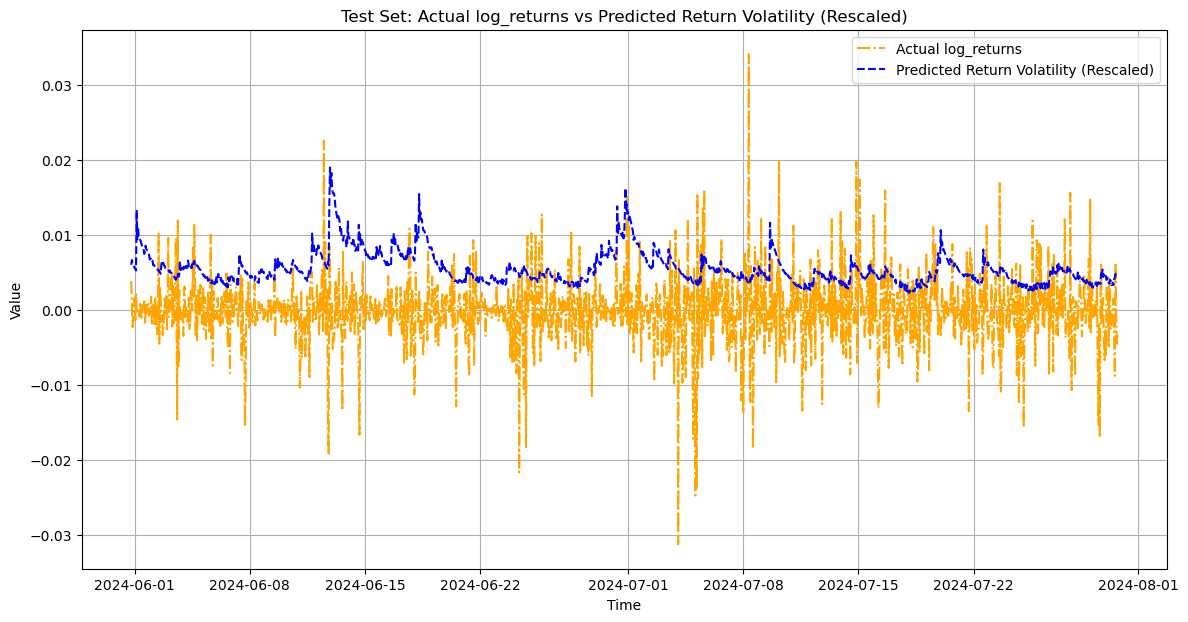

General Train MAE: 0.006331
General Test MAE: 0.006256


In [12]:
# Parameters are set
steps = len(test_df)
test_mae_values = []
train_mae_values = []
test_length = len(test_df)

# All predictions and actual values are stored for the final combined plot
test_rolling_predictions = []
test_all_actuals = []

# Model training and rolling prediction are conducted without a gap
for i in range(test_length):
    # The appropriate training set is used for this iteration
    train_set = train_df['log_returns_100'][:-(test_length-i)].copy()
    
    # A GJR-GARCH model with o=1 and skewt distribution is defined
    model = arch_model(train_set, vol='GARCH', p=1, q=2, o=1, mean='Constant', dist='skewt')
    model_fit = model.fit(disp='off')
    
    # A train prediction is made
    train_pred = model_fit.conditional_volatility[-1] / 100  # The last train prediction is obtained and rescaled
    
    # MAE for the train set is calculated
    train_mae = mean_absolute_error([train_set.iloc[-1] / 100], [train_pred])
    train_mae_values.append(train_mae)
    
    # A test prediction is made
    val_pred = model_fit.forecast(horizon=1)
    val_pred_rescaled = np.sqrt(val_pred.variance.values[-1, :]) / 100

    # The prediction and actual volatility are stored
    test_rolling_predictions.append(val_pred_rescaled[0])
    test_all_actuals.append(test_df['volatility'].iloc[i])
    
    # MAE for validation is calculated (with rescaled predictions)
    test_mae = mean_absolute_error([test_df['log_returns_100'].iloc[i] / 100], val_pred_rescaled)
    test_mae_values.append(test_mae)

# A final combined plot for the test set is created
plt.figure(figsize=(14, 7))
plt.plot(test_df.index[:test_length], test_df['log_returns_100'] / 100, label='Actual log_returns', color='orange', linestyle='-.')
plt.plot(test_df.index[:test_length], test_rolling_predictions, label='Predicted Return Volatility (Rescaled)', color='blue', linestyle='--')
plt.title('Test Set: Actual log_returns vs Predicted Return Volatility (Rescaled)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# General MAE for the train and test sets is calculated
general_train_mae = np.mean(train_mae_values)
general_test_mae = np.mean(test_mae_values)

print(f"General Train MAE: {general_train_mae:.6f}")
print(f"General Test MAE: {general_test_mae:.6f}")

In this code, there is no risk of data leakage. The reason is that there is a clear separation between the training and testing data. According to the operation of the code, only the data in the training set is used for model training during each prediction step. Any data from the test set is not used during the model training process.

More specifically:
* Training Set and Test Set: The statement train_set = train_df['log_returns_100'][:-(test_length-i)].copy() ensures that only the train_df data is used for training the model in each iteration. The test data, i.e., test_df, is not used during model training. The training data dynamically changes in each iteration to update the model training.
* Predictions: The predictions are made based on the training set, and then they are compared with the actual volatility values from the test set.

##### This approach eliminates the possibility of data leakage because the model does not “see” or learn from the test data during training.

## 4. Comparison Between Predicted Return Volatility & Price

/var/folders/wl/n7pq_5rj1bz43l8jft3ps3q40000gp/T/ipykernel_1206/1733979897.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['futures_btc_close_price_scaled'] = scaler.fit_transform(test_df[['futures_btc_close_price']])
/var/folders/wl/n7pq_5rj1bz43l8jft3ps3q40000gp/T/ipykernel_1206/1733979897.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_log_returns_scaled'] = scaler.fit_transform(np.array(test_rolling_predictions).reshape(-1, 1))


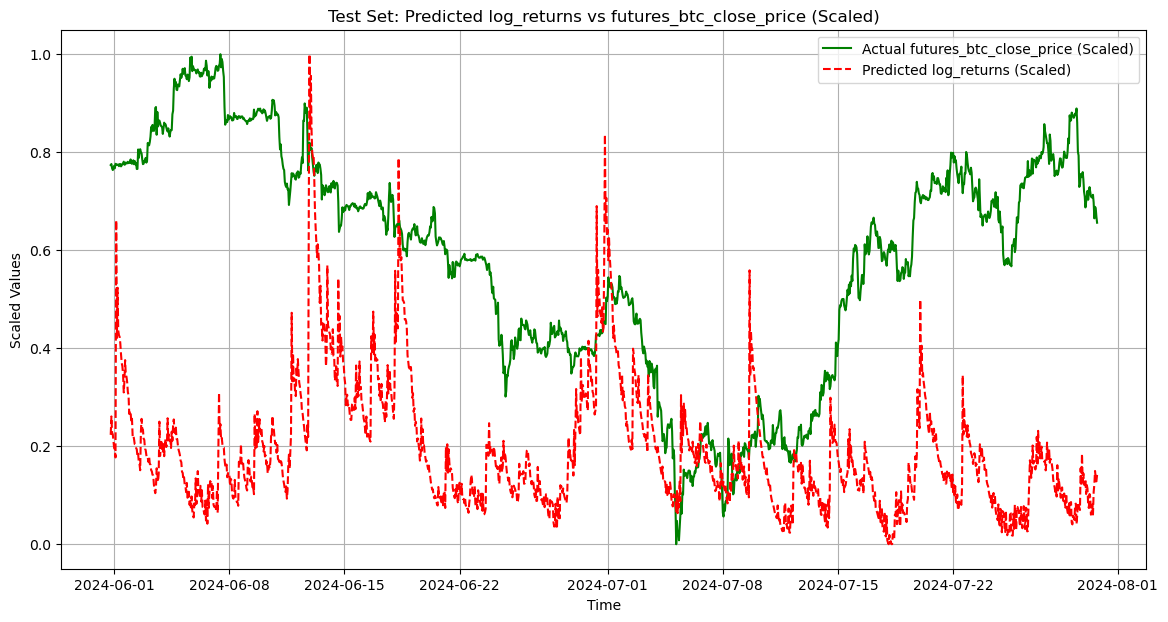

In [13]:
# The MinMaxScaler is defined, and scaling is done between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
test_df['futures_btc_close_price_scaled'] = scaler.fit_transform(test_df[['futures_btc_close_price']])
test_df['predicted_log_returns_scaled'] = scaler.fit_transform(np.array(test_rolling_predictions).reshape(-1, 1))
plt.figure(figsize=(14, 7))

# Actual futures_btc_close_price (Scaled) is plotted
plt.plot(test_df.index[:test_length], test_df['futures_btc_close_price_scaled'], label='Actual futures_btc_close_price (Scaled)', color='green', linestyle='-')
plt.plot(test_df.index[:test_length], test_df['predicted_log_returns_scaled'], label='Predicted log_returns (Scaled)', color='red', linestyle='--')

plt.title('Test Set: Predicted log_returns vs futures_btc_close_price (Scaled)')
plt.xlabel('Time')
plt.ylabel('Scaled Values')
plt.legend()
plt.grid(True)
plt.show()

## 5. Conclusion

When analyzing the graphs, especially the relationship between predicted log returns and the futures BTC close price, several key points stand out:

#### Relationship Between Predicted Return Volatility and Bitcoin Price
* The predicted return volatility are represented by the red dashed line in the graph, while the Bitcoin closing price is shown by the green line.
* The most important point to note is that the predicted return volatility values typically peak just before price drops. This can be an indicator of high volatility (rapid price changes).
* For instance, around the dates 2024-06-15 and 2024-07-01, there are noticeable peaks in the predicted log returns. Immediately following these peaks, significant declines in Bitcoin prices are observed.
#### Liquidation Cascades
* Liquidation cascades are defined as chain reactions of forced liquidations that cause rapid price drops. These situations typically occur when highly leveraged positions are quickly closed.
* The moments when predicted return volatility are high could signal the potential start of liquidation cascades. In such cases, high volatility can cause the price to drop rapidly, leading to the liquidation of positions.
*  The consistency observed between the peaks in predicted return volatility and subsequent price drops suggests that the model may have the potential to predict liquidation cascades.
#### Overall Analysis

* The model shows a certain degree of success, particularly in predicting large increases in volatility followed by price drops. The peaks in the predicted return volatility often correspond with significant declines in Bitcoin prices.
* This indicates that the model is effectively capturing periods of high volatility and has the potential to predict liquidation cascades in advance.
* However, it’s noteworthy that the model may struggle to capture low volatility and smaller price movements accurately. Its performance may decrease under calm market conditions.
* When the predicted return volatilities spike, the model’s ability to relate these instances to increases in volatility and subsequent price declines demonstrates its potential in forecasting liquidation cascades.

##### Conclusion

* The analysis of the graphs suggests that the model could be successful in capturing liquidation cascades. However, to improve the accuracy of these predictions, it is important to enhance the model’s sensitivity and responsiveness. Specifically, the model’s performance during low volatility periods can be improved.
* The ability of the model to accurately predict liquidation cascades could provide significant advantages to investors and traders. Such insights could play a crucial role in risk management strategies and in managing positions more effectively.

## 6. Saving Predictions for LSTM

In [ ]:
predictions_df = pd.DataFrame({
    'Date': test_df.index[:test_length],
    'Predicted_log_returns': test_rolling_predictions,
    'Actual_Volatility': test_all_actuals
})

In [ ]:
predictions_df.to_csv('predicted_log_returns_gjr.csv', index=False)